# Wengert lists

## Warning: This notebook is under construction- please ignore.

In this notebook I will lay out the concept of Wengert lists, and how they are used in automatic differentiation.
Finally, I will write a code implementation I can use with the neural network I have already written.

## Motivation

Finding derivatives, gradients, Jacobians, etc, can be a difficult task. Computationally we are limited to a few methods of computing these functions, and fewer are numerically stable. Let's quickly remind ourselves of what the derivative is. The derivative $\frac{df}{dx}$ of function $f: \mathbb{R}\mapsto \mathbb{R}$

$$
\frac{df}{dx}=\lim_{\Delta \to 0}\frac{f(x+\Delta)-f(x)}{\Delta}
$$
One can quickly be tempted to use this definition as an approximation of the derivatives. Like this:
$$
\frac{df}{dx}\approx\frac{f(x+\Delta)-f(x)}{\Delta}
$$
letting $\Delta$ be a small number. 
<br>
This is not the best idea because, as mentioned above, it is not numerically stable. Let me demonstrate with the function 
$$
f(x)=e^{-x^2+3x-2}+e^{\arctan{(x)}e^{-x/2}}
$$
   

The smallest error eps = 1.15591e-10 was with delta = 3.81944e-09


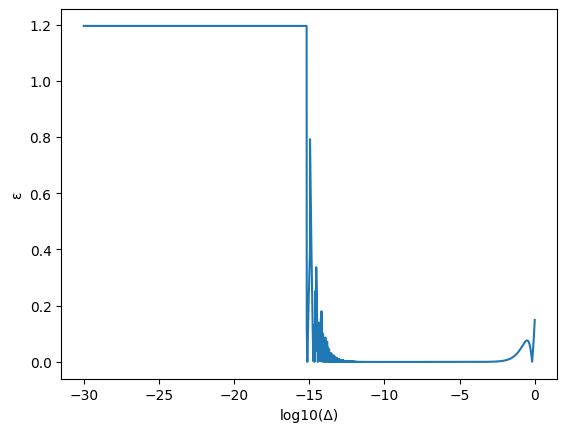

In [1]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.exp(-(x**2-3*x+2))+np.exp(np.arctan(x)*np.exp(-x/2))

def dfdx(x):
    term1 = np.exp(-x**2+3*x-2)*(3-2*x)
    term2 = np.exp(np.exp(-x/2)*np.arctan(x))
    term3 = np.exp(-x/2)/(x**2+1)-1/2*np.exp(-x/2)*np.arctan(x)
    term4 = term2*term3
    return term1 + term4

def finite_diff(f, x, delta):
    return (f(x+delta)-f(x))/delta

def error(analytical, numerical):
    return np.abs(analytical-numerical)
    
n = 10000
x = np.linspace(-2,2,n)



deltas = np.logspace(-30, 0, n+1)
eps = np.zeros(n+1)
a = 2

analytical = dfdx(a)

for i, delta in enumerate(deltas, start = 0):
    numerical = finite_diff(f, a, delta)
    eps[i] = error(analytical, numerical)

fig, ax = plt.subplots()
ax.plot(np.log10(deltas), eps)
plt.xlabel("log10(Δ)")
plt.ylabel("ε")

print("The smallest error eps = %g was with delta = %g" %(np.min(eps), deltas[np.argmin(eps)]))

We can se that for $\Delta < 10^{-13}$ (circa), the formula becomes very unstable. And we never really get a precice value for $\frac{df}{dx}\Biggr|_{x=2}$; we're off by $\sim 10^{-10}$. That is to say: an error on the magnitude of $10^{-10}$ is a decent enough result if we're to evaluete the derivative of one function at one point, but the numerical instability of the finite difference method rules it out as a way to compute derivatives. Luckily there is an alternative way of computing the derivative, and it does not require us to do it analytically (or however it is WolframAlpha does is). It is called automatic differentiation.  

Let's do some AuToMaTiC dIfFeReNtIaTiOn!

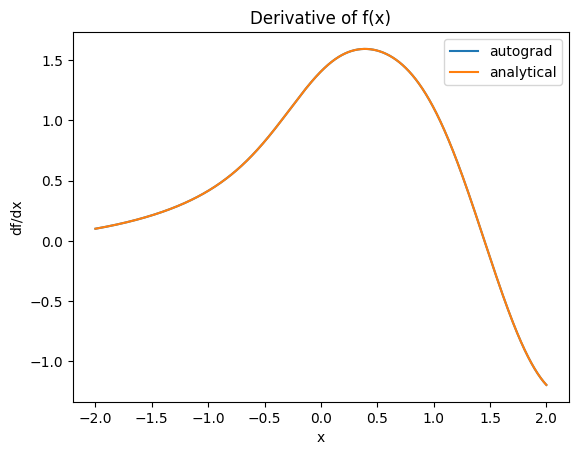

In [5]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
autoDiff = egrad(f)

plt.plot(x, autoDiff(x), label = "autograd")
plt.plot(x,dfdx(x), label = "analytical")
plt.xlabel("x")
plt.ylabel("df/dx")
plt.title("Derivative of f(x)")
plt.legend()

It seems the autograd is quite close, but it's hard to tell. Let's check the maximum error.

In [3]:
absoluteError = np.abs(autoDiff(x)-dfdx(x))
print(np.max(absoluteError))


8.881784197001252e-16


A significant improvement to the previous result with the finite difference method. But how does this magic work? I will try to explain. The key words are "computational graphs". Let' just jump right in. Let's start by defining a funtion $f$, such that


$$
f(x_1,x_2) = x_1x_2\sin{x_2}
$$


We can represent this function with the following computational graph (that i stole from https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6).


![uh!](https://miro.medium.com/v2/resize:fit:720/format:webp/1*N_VV1FmBRzDOOJHBA3FQEQ.png)

with 
$$
v_1=x_1=2
$$
$$
v_2=x_2=3
$$

Now doesn't that look a little like this a artificial neural network?

![uuuhh](https://victorzhou.com/media/nn-series/network.svg)

Foreshadowing, right? But you might want to know how this actually relates to derivatives. I'll show you:
$$
\dot{v_i}=\frac{\partial v_i}{\partial x_j}
$$


Let's evaluate all these derivatives

$$
\dot{v_1}=\frac{\partial x_1}{\partial x_2}=0
$$
$$
\dot{v_2}=\frac{\partial x_2}{\partial x_2}=1
$$
$$
\dot{v_3}=\dot{v_1}v_2+v_1\dot{v_2}=2
$$
$$
\dot{v_4}=\frac{\partial}{\partial v_2}\sin{v_2}=\cos{v_2}=\cos{3}
$$
$$
\dot{v_5}=\dot{v_3}-\dot{v_4}=2-\cos{3}\approx 3
$$

Now you might think that this is a bit a heavy, to only get the partial derivatives w.r.t. $x_2$. Let's now consider general vector valued functions:
$$
f:\mathbb{R}^n\mapsto\mathbb{R}^m
$$
and its derivatives in the form of the Jacobian matrix $J_f$
$$
J_f=
\begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n}\\
\vdots & \ddots & \vdots\\
\frac{\partial y_m}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_n}\\
\end{pmatrix}
$$

We can see that using the method we used for finding the derivatives (forward mode) must be really slow when working with large $n, m$

In [6]:
class Variable():
    def __init__(self, f, d = 0):
        self.f = f
        self.d = d
    
    def __repr__(self):
        # The "representation" of this class. Meaning the text that will
        # be printed when we use the class.
        return f"Variable(f={self.f}, d={self.d})"

    def __add__(self, other): # other + self
        return Variable(self.f + other.f, self.d + other.d)

    def __radd__(self, other): # other + self
        return Variable(other.f + self.f, other.d + self.d)

    def __sub__(self, other): # self - other
        return Variable(self.f - other.f, self.d - other.d)

    def __rsub__(self, other): # other - self
        return Variable(other.f - self.f, other.d - self.d)

    def __mul__(self, other): # self * other
        return Variable(self.f * other.f, other.f * self.d + other.d * self.f)

    def __rmul__(self, other): # other * self
        return Variable(self.f * other.f, self.f * other.d + self.d * other.f)

    def __truediv__(self, other): # self / other
        return Variable(self.f / other.f, (self.d * other.f - self.f * other.d) / other.f**2)

    def __rtruediv__(self, other): # other / self
        return Variable(other.f / self.f, (other.d * self.f - other.f * self.d) / self.f**2)
    
    def sin(self):
        return Variable(np.sin(self.f), np.cos(self.f) * self.d)

    def cos(self):
        return Variable(np.cos(self.f), -np.sin(self.f) * self.d)

    def tan(self):
        return self.sin()/self.cos()

    def log(self):
        return Variable(np.log(self.f), 1/self.f * self.d)
    
    def exp(self):
        return Variable(np.exp(self.f), np.exp(self.f) * self.d)

    def __pow__(self, number):
        assert isinstance(number, (int, float)), "only supporting int/float powers"
        return Variable(np.power(self.f, number), number * np.power(self.f, number - 1) * self.d)

In [18]:
2.0000000000001+2.0

4.0000000000000995